In [1]:
!git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
!pip install kornia e2cnn

!pwd
%cd /content/singular_points
!pwd

Cloning into 'singular_points'...
remote: Enumerating objects: 1509, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 1509 (delta 227), reused 330 (delta 213), pack-reused 1164
Receiving objects: 100% (1509/1509), 164.65 MiB | 15.41 MiB/s, done.
Resolving deltas: 100% (230/230), done.
Updating files: 100% (1198/1198), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 29.3 MB/s eta 0:00:00
/content
/content/singular_points
/content/singular_points


In [2]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 3*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(
                enn.MaskModule(feat_type_in, n_dim, margin=2),
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 12*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=7, padding=0, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        
        feat_type_in  = self.block2.out_type
        feat_type_out = enn.FieldType(r2_act, 3*[r2_act.regular_repr])
        self.block3 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=7, padding=0, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                # enn.MaskModule(feat_type_out, 13, margin=2)
                )
        
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)        
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gpool(x)        
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        self.dense1 = nn.Linear(2*3*13*13, 1024)
        self.dense2 = nn.Linear(1024, 256)
        self.dense3 = nn.Linear(256, 64)
        self.dense4 = nn.Linear(64, 1)
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation = nn.Sigmoid()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
      
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.activation(x)
        return x


class Siamesa(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_dim=n_dim,n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x
    

X1=torch.ones(8,2,31,31).to(device)

model =Siamesa(n_dim=31,n_channel=2).to(device)
model(X1,X1)

tensor([[0.4996],
        [0.4996],
        [0.4996],
        [0.4996],
        [0.4996],
        [0.4996],
        [0.4996],
        [0.4996]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [4]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = 0.5
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    loss = torch.mean(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=0,translate=(0.1,0.1),scale=(0.9,1.1))(x)
    return x


### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [5]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 15
    args.margin_loss = 2.0
    args.border  = 15
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

100%|██████████| 344862509/344862509 [00:01<00:00, 209813157.32it/s]


Extracting data/datasets/flowers-102/102flowers.tgz to data/datasets/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1832498.35it/s]


100%|██████████| 14989/14989 [00:00<00:00, 21604268.95it/s]
/usr/local/lib/python3.10/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Já foi treinado
epoca 100 loss 3.5150668924930053
10 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Segementa todas as features de batch só

pos predict  torch.Size([10, 1, 180, 180]) torch.Size([10, 1, 180, 180])
torch.Size([821, 31, 31]) torch.Size([821, 31, 31]) torch.Size([821, 2, 31, 31])


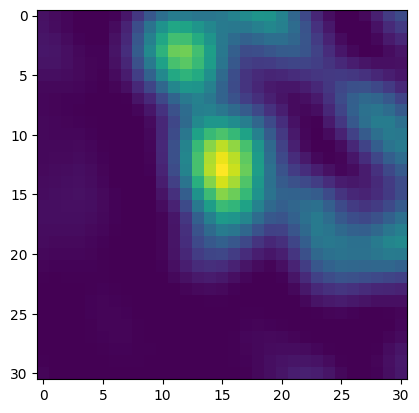

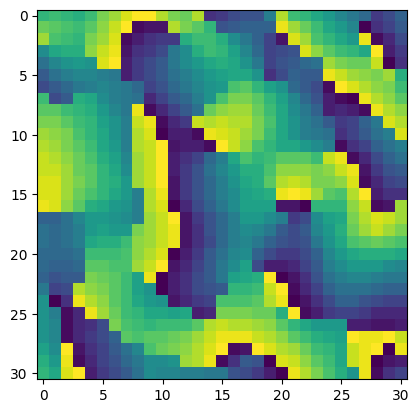

In [6]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

# concatena em um tensor somente as features e orientações
for i,(boxs,mini_feat_batch,mini_orien_batch) in enumerate(batch_result):
    if i==0:
        mini_feat_batch_concat = mini_feat_batch
        mini_orien_batch_concat = mini_orien_batch
    else:
        mini_feat_batch_concat = torch.cat([mini_feat_batch_concat,mini_feat_batch], dim=0)
        mini_orien_batch_concat = torch.cat([mini_orien_batch_concat,mini_orien_batch], dim=0)
    # print('batch ',i,mini_orien_batch_concat.shape)

mini_dataloader = torch.stack([mini_feat_batch_concat,mini_orien_batch_concat], dim=1)
print(mini_feat_batch_concat.shape,mini_orien_batch_concat.shape,mini_dataloader.shape)

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [7]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 10

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.8
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


66
17


In [68]:
model =Siamesa(n_dim=31,n_channel=2).to(device)
model(X1,X1)

tensor([[0.4283],
        [0.4283],
        [0.4283],
        [0.4283],
        [0.4283],
        [0.4283],
        [0.4283],
        [0.4283]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [70]:
def train(model,train_loader,test_loader,loss_fn,epochs=10,device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
    for epoch in range(epochs):
        loss_train = train_one_epoch(model,train_loader,optimizer,loss_fn,device)
        loss_test = test(model,test_loader,loss_fn,device)
        print()
        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')
        

train(model,train_loader,test_loader,loss_fn,epochs=100,device=device)

Tests : 100%|██████████| 17/17 [00:00<00:00, 28.11it/s]



Epoch: 0, Train Loss: 0.0422, Test Loss: 0.0423


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.58it/s]



Epoch: 1, Train Loss: 0.0411, Test Loss: 0.0433


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.88it/s]



Epoch: 2, Train Loss: 0.0415, Test Loss: 0.0417


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.31it/s]



Epoch: 3, Train Loss: 0.0414, Test Loss: 0.0437


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.43it/s]



Epoch: 4, Train Loss: 0.0402, Test Loss: 0.0458


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.20it/s]



Epoch: 5, Train Loss: 0.0412, Test Loss: 0.0423


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.17it/s]



Epoch: 6, Train Loss: 0.0417, Test Loss: 0.0437


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.16it/s]



Epoch: 7, Train Loss: 0.0405, Test Loss: 0.0423


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.94it/s]



Epoch: 8, Train Loss: 0.0404, Test Loss: 0.0438


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.32it/s]



Epoch: 9, Train Loss: 0.0411, Test Loss: 0.0443


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.20it/s]



Epoch: 10, Train Loss: 0.0406, Test Loss: 0.0413


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.45it/s]



Epoch: 11, Train Loss: 0.0413, Test Loss: 0.0440


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.12it/s]



Epoch: 12, Train Loss: 0.0411, Test Loss: 0.0414


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.87it/s]



Epoch: 13, Train Loss: 0.0396, Test Loss: 0.0393


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.22it/s]



Epoch: 14, Train Loss: 0.0411, Test Loss: 0.0421


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.09it/s]



Epoch: 15, Train Loss: 0.0415, Test Loss: 0.0428


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.49it/s]



Epoch: 16, Train Loss: 0.0421, Test Loss: 0.0393


Tests : 100%|██████████| 17/17 [00:00<00:00, 25.16it/s]



Epoch: 17, Train Loss: 0.0397, Test Loss: 0.0421


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.00it/s]



Epoch: 18, Train Loss: 0.0400, Test Loss: 0.0424


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.86it/s]



Epoch: 19, Train Loss: 0.0399, Test Loss: 0.0407


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.25it/s]



Epoch: 20, Train Loss: 0.0404, Test Loss: 0.0423


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.02it/s]



Epoch: 21, Train Loss: 0.0400, Test Loss: 0.0418


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.16it/s]



Epoch: 22, Train Loss: 0.0401, Test Loss: 0.0388


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.39it/s]



Epoch: 23, Train Loss: 0.0395, Test Loss: 0.0389


Tests : 100%|██████████| 17/17 [00:00<00:00, 25.72it/s]



Epoch: 24, Train Loss: 0.0396, Test Loss: 0.0392


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.58it/s]



Epoch: 25, Train Loss: 0.0388, Test Loss: 0.0396


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.15it/s]



Epoch: 26, Train Loss: 0.0389, Test Loss: 0.0429


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.25it/s]



Epoch: 27, Train Loss: 0.0404, Test Loss: 0.0407


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.77it/s]



Epoch: 28, Train Loss: 0.0394, Test Loss: 0.0410


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.39it/s]



Epoch: 29, Train Loss: 0.0384, Test Loss: 0.0422


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.21it/s]



Epoch: 30, Train Loss: 0.0402, Test Loss: 0.0430


Tests : 100%|██████████| 17/17 [00:00<00:00, 25.83it/s]



Epoch: 31, Train Loss: 0.0384, Test Loss: 0.0390


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.50it/s]



Epoch: 32, Train Loss: 0.0392, Test Loss: 0.0428


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.36it/s]



Epoch: 33, Train Loss: 0.0372, Test Loss: 0.0396


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.91it/s]



Epoch: 34, Train Loss: 0.0398, Test Loss: 0.0445


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.28it/s]



Epoch: 35, Train Loss: 0.0389, Test Loss: 0.0411


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.18it/s]



Epoch: 36, Train Loss: 0.0376, Test Loss: 0.0405


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.29it/s]



Epoch: 37, Train Loss: 0.0387, Test Loss: 0.0411


Tests : 100%|██████████| 17/17 [00:00<00:00, 25.67it/s]



Epoch: 38, Train Loss: 0.0395, Test Loss: 0.0413


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.18it/s]



Epoch: 39, Train Loss: 0.0382, Test Loss: 0.0412


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.11it/s]



Epoch: 40, Train Loss: 0.0394, Test Loss: 0.0403


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.27it/s]



Epoch: 41, Train Loss: 0.0396, Test Loss: 0.0393


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.06it/s]



Epoch: 42, Train Loss: 0.0383, Test Loss: 0.0384


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.32it/s]



Epoch: 43, Train Loss: 0.0398, Test Loss: 0.0398


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.86it/s]



Epoch: 44, Train Loss: 0.0389, Test Loss: 0.0438


Tests : 100%|██████████| 17/17 [00:00<00:00, 25.93it/s]



Epoch: 45, Train Loss: 0.0385, Test Loss: 0.0397


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.63it/s]



Epoch: 46, Train Loss: 0.0372, Test Loss: 0.0372


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.25it/s]



Epoch: 47, Train Loss: 0.0405, Test Loss: 0.0404


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.12it/s]



Epoch: 48, Train Loss: 0.0388, Test Loss: 0.0379


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.13it/s]



Epoch: 49, Train Loss: 0.0391, Test Loss: 0.0411


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.05it/s]



Epoch: 50, Train Loss: 0.0398, Test Loss: 0.0414


Tests : 100%|██████████| 17/17 [00:00<00:00, 28.05it/s]



Epoch: 51, Train Loss: 0.0371, Test Loss: 0.0402


Tests : 100%|██████████| 17/17 [00:00<00:00, 25.60it/s]



Epoch: 52, Train Loss: 0.0385, Test Loss: 0.0386


Train :  33%|███▎      | 22/66 [00:03<00:07,  6.23it/s]


KeyboardInterrupt: ignored

### Teste com a rede siamesa

In [72]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [73]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


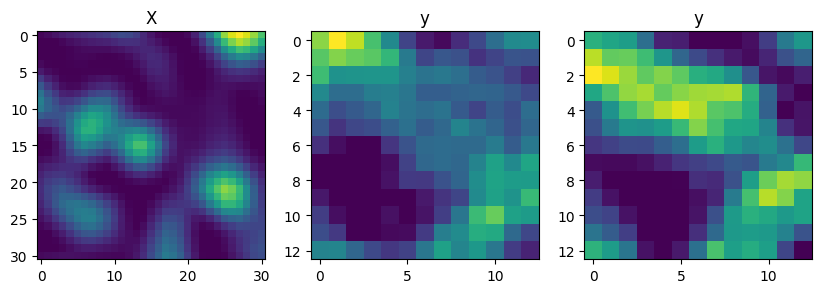

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.1171, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.4211, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.0887, device='cuda:0') tensor([0.0222], device='cuda:0')


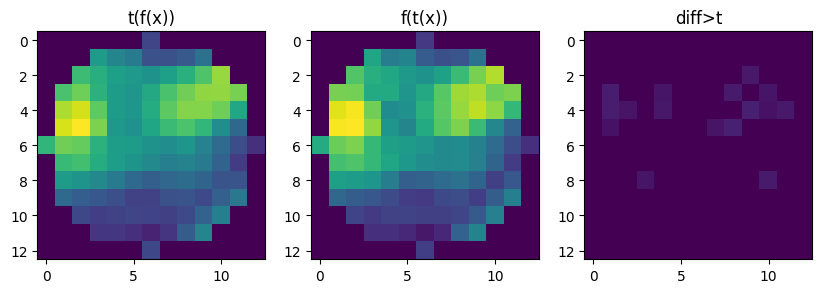

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.3793, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.3793, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor([0.0021], device='cuda:0')


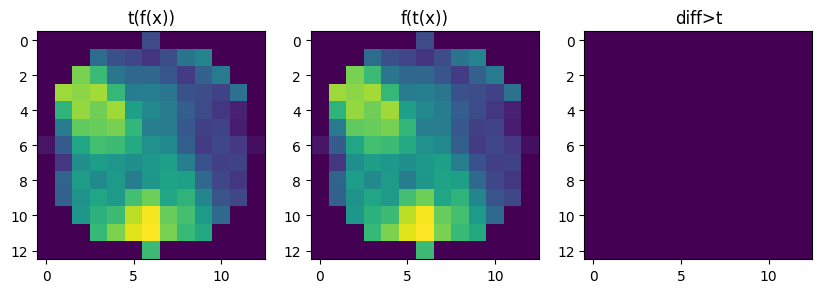

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.3343, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.4220, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor([0.0006], device='cuda:0')


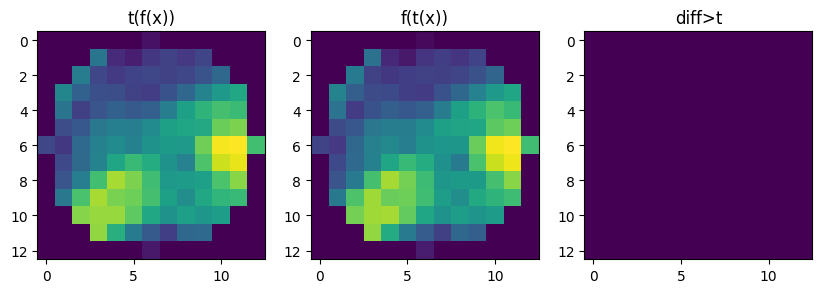

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.1009, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.4734, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1158, device='cuda:0') tensor([0.0049], device='cuda:0')


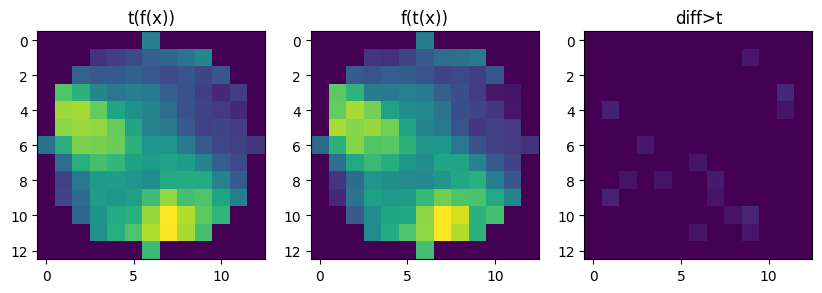

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.1729, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.3579, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1250, device='cuda:0') tensor([0.0033], device='cuda:0')


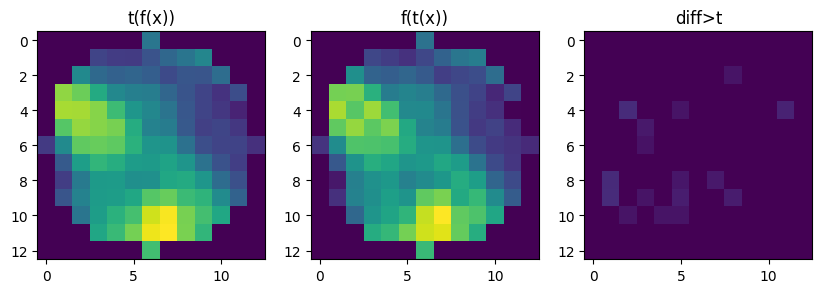

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.1359, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.4274, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1297, device='cuda:0') tensor([0.0161], device='cuda:0')


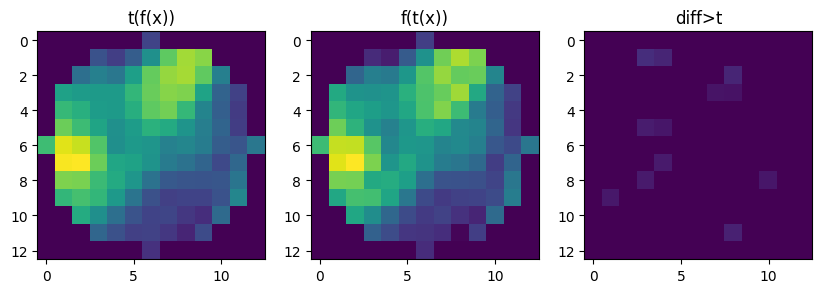

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.2949, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.3633, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1146, device='cuda:0') tensor([0.0080], device='cuda:0')


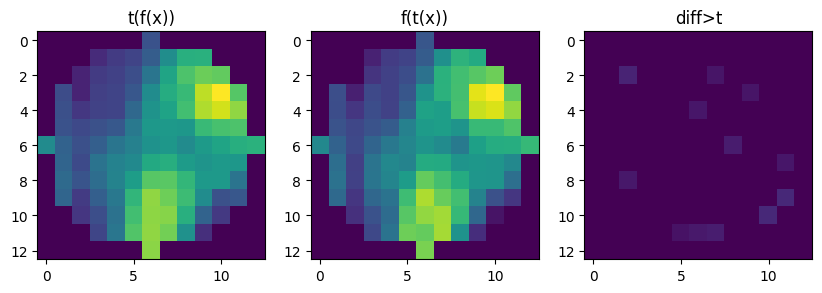

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.3793, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.3793, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor([0.0005], device='cuda:0')


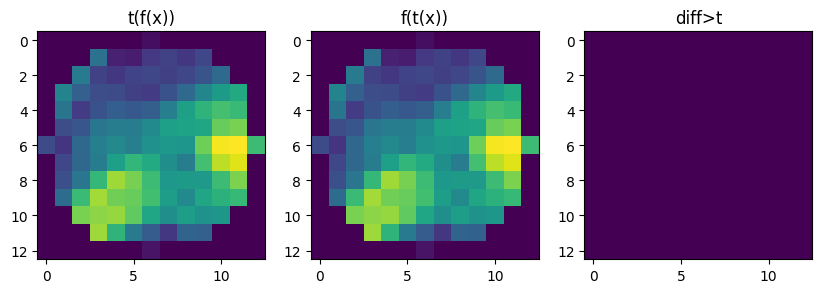

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.1009, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.4734, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1158, device='cuda:0') tensor([0.0382], device='cuda:0')


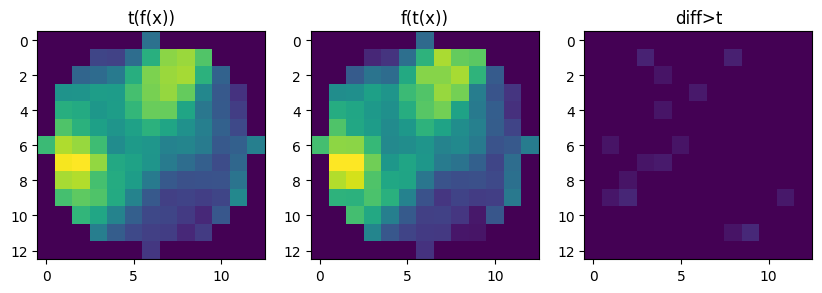

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.1591, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(5.4295, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1277, device='cuda:0') tensor([0.0028], device='cuda:0')


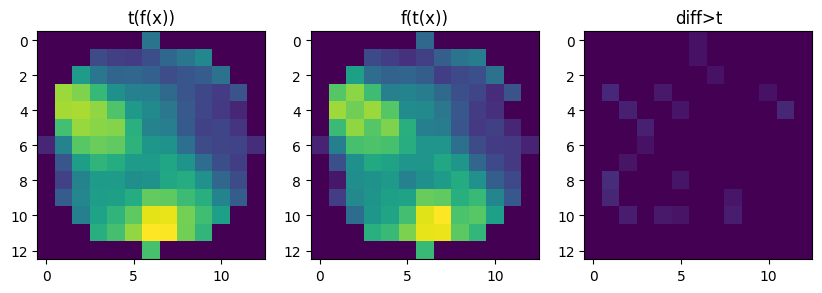

In [77]:
model_feature = model.feature
model_discriminator = model.discriminator

torch.manual_seed(42)
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)

c_mask = create_circular_mask(y.shape[2],y.shape[3])
c_mask = torch.tensor(c_mask).to(device)

iterator=iter(test_loader)
data = next(iterator)
index = 5 
with torch.no_grad():
    y = model_feature(data)
    show_images(normalize_tensor(data[index,0]),normalize_tensor(y[index,2]),normalize_tensor(y[index,1]),title1="X",title2="y",title3="y")
    for angle in angles:
        data_rotated, y_rotated = rotate_images(data, y, angle)
        y_rotated2 = model_feature(data_rotated)
        
        distance =model_discriminator(y_rotated,y_rotated2)
        y_rotated2 = y_rotated2*c_mask
        y_rotated = y_rotated*c_mask

        y1n=normalize_tensor(y_rotated[0,0])
        y2n=normalize_tensor(y_rotated2[0,0])

        print(y1n.min(),y_rotated.min(),y1n.max(),y_rotated.max())
        print(y2n.min(),y_rotated2.min(),y2n.max(),y_rotated2.max())
        
        diff = abs(y2n - y1n)
        t = 0.05
        diff[abs(diff) < t] = 0

        print(diff.min(),diff.max(),distance[0])
        show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

In [75]:
def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

iterator=iter(test_loader)
data = next(iterator)
size = len(data)
with torch.no_grad():
  for i in range(size):
    img_temp = data[i][None]
    data_temp = copy_tensor(img_temp,size)
    # print(img_temp.shape,data_temp.shape)
    distances = model(data,data_temp)
    print("index: ",i," found in ",distances.argmin().item()," position ")

index:  0  found in  5  position 
index:  1  found in  5  position 
index:  2  found in  5  position 
index:  3  found in  5  position 
index:  4  found in  5  position 
index:  5  found in  5  position 
index:  6  found in  5  position 
index:  7  found in  5  position 
index:  8  found in  5  position 
index:  9  found in  5  position 


In [76]:
data_temp = copy_tensor(data[1][None],10)
dist = model(data,data_temp)
print(dist.argmin().item(),dist)
dist = model(data,data)
print(dist.argmin().item(),dist)

5 tensor([[1.0484e-01],
        [1.9915e-02],
        [3.3595e-03],
        [2.3701e-01],
        [1.6478e-05],
        [3.4228e-09],
        [7.3096e-06],
        [5.2417e-08],
        [2.4849e-07],
        [2.5088e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)
5 tensor([[0.0662],
        [0.0148],
        [0.0196],
        [0.0265],
        [0.0062],
        [0.0005],
        [0.0057],
        [0.0060],
        [0.0088],
        [0.0146]], device='cuda:0', grad_fn=<SigmoidBackward0>)
